# Dependencies and files

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import plotly.graph_objects as go
from IPython.display import Image


import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests
import utils.cluster_visualisation as vis

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, leaves_list
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_kernels

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
figures_dir = f'human_specific_genes/figures/'
os.makedirs(figures_dir, exist_ok=True)

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
color_dict_labels = {'human-specific': 'tab:blue', 'age-specific': 'tab:orange', 'maybe human-specific': 'tab:red', 'maybe age-specific': 'tab:green'}

In [5]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown', 'cyan', 'pink', 'violet', 'crimson']

In [6]:
specie_palette = {
    "human": "tab:red",
    "chimp": "tab:orange",
    "macaque": "tab:green"
}

## Load files

In [7]:
pb_dir_path = 'data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_chimp.h5ad',
 'pb_human.h5ad',
 'pb_macaque.h5ad',
 'pb_mammals.h5ad',
 'pb_spatial_libd_human.h5ad',
 'pseudobulk_all_four.h5ad',
 'pseudobulk_all_mammals.h5ad',
 'pseudobulk_humans.h5ad']

In [9]:
adata_pb = sc.read_h5ad(pb_dir_path + 'pseudobulk_all_mammals.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 89 × 9209
    obs: 'layer', 'sample_id', 'psbulk_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'X_pca_mean_norm', 'condition_colors', 'layer_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_mean_norm'
    varm: 'PCs', 'X_pca_mean_norm'
    layers: 'counts', 'mean_norm', 'psbulk_props'

## Human-specific genes

In [10]:
filepath = f'data/human_specific_genes/gene_groups.csv'
category_labels = pd.read_csv(filepath, index_col=0)['label']
category_labels = category_labels[category_labels.isin(["human-specific", "maybe human-specific"])].dropna()
hs_genes = category_labels.index
category_labels.head()

CHST10    maybe human-specific
GDE1      maybe human-specific
KLHL2           human-specific
TMED3           human-specific
VAT1L     maybe human-specific
Name: label, dtype: object

In [11]:
with open('data/human_specific_genes/background_genes.txt', 'r') as f:
    background_genes = f.read().split(",")

len(background_genes)

7801

# Clusterisation

In [12]:
df = pd.DataFrame(adata_pb.layers["mean_norm"], index=adata_pb.obs_names, columns=adata_pb.var_names)

In [13]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes].copy()

Complete hierarchical clustering

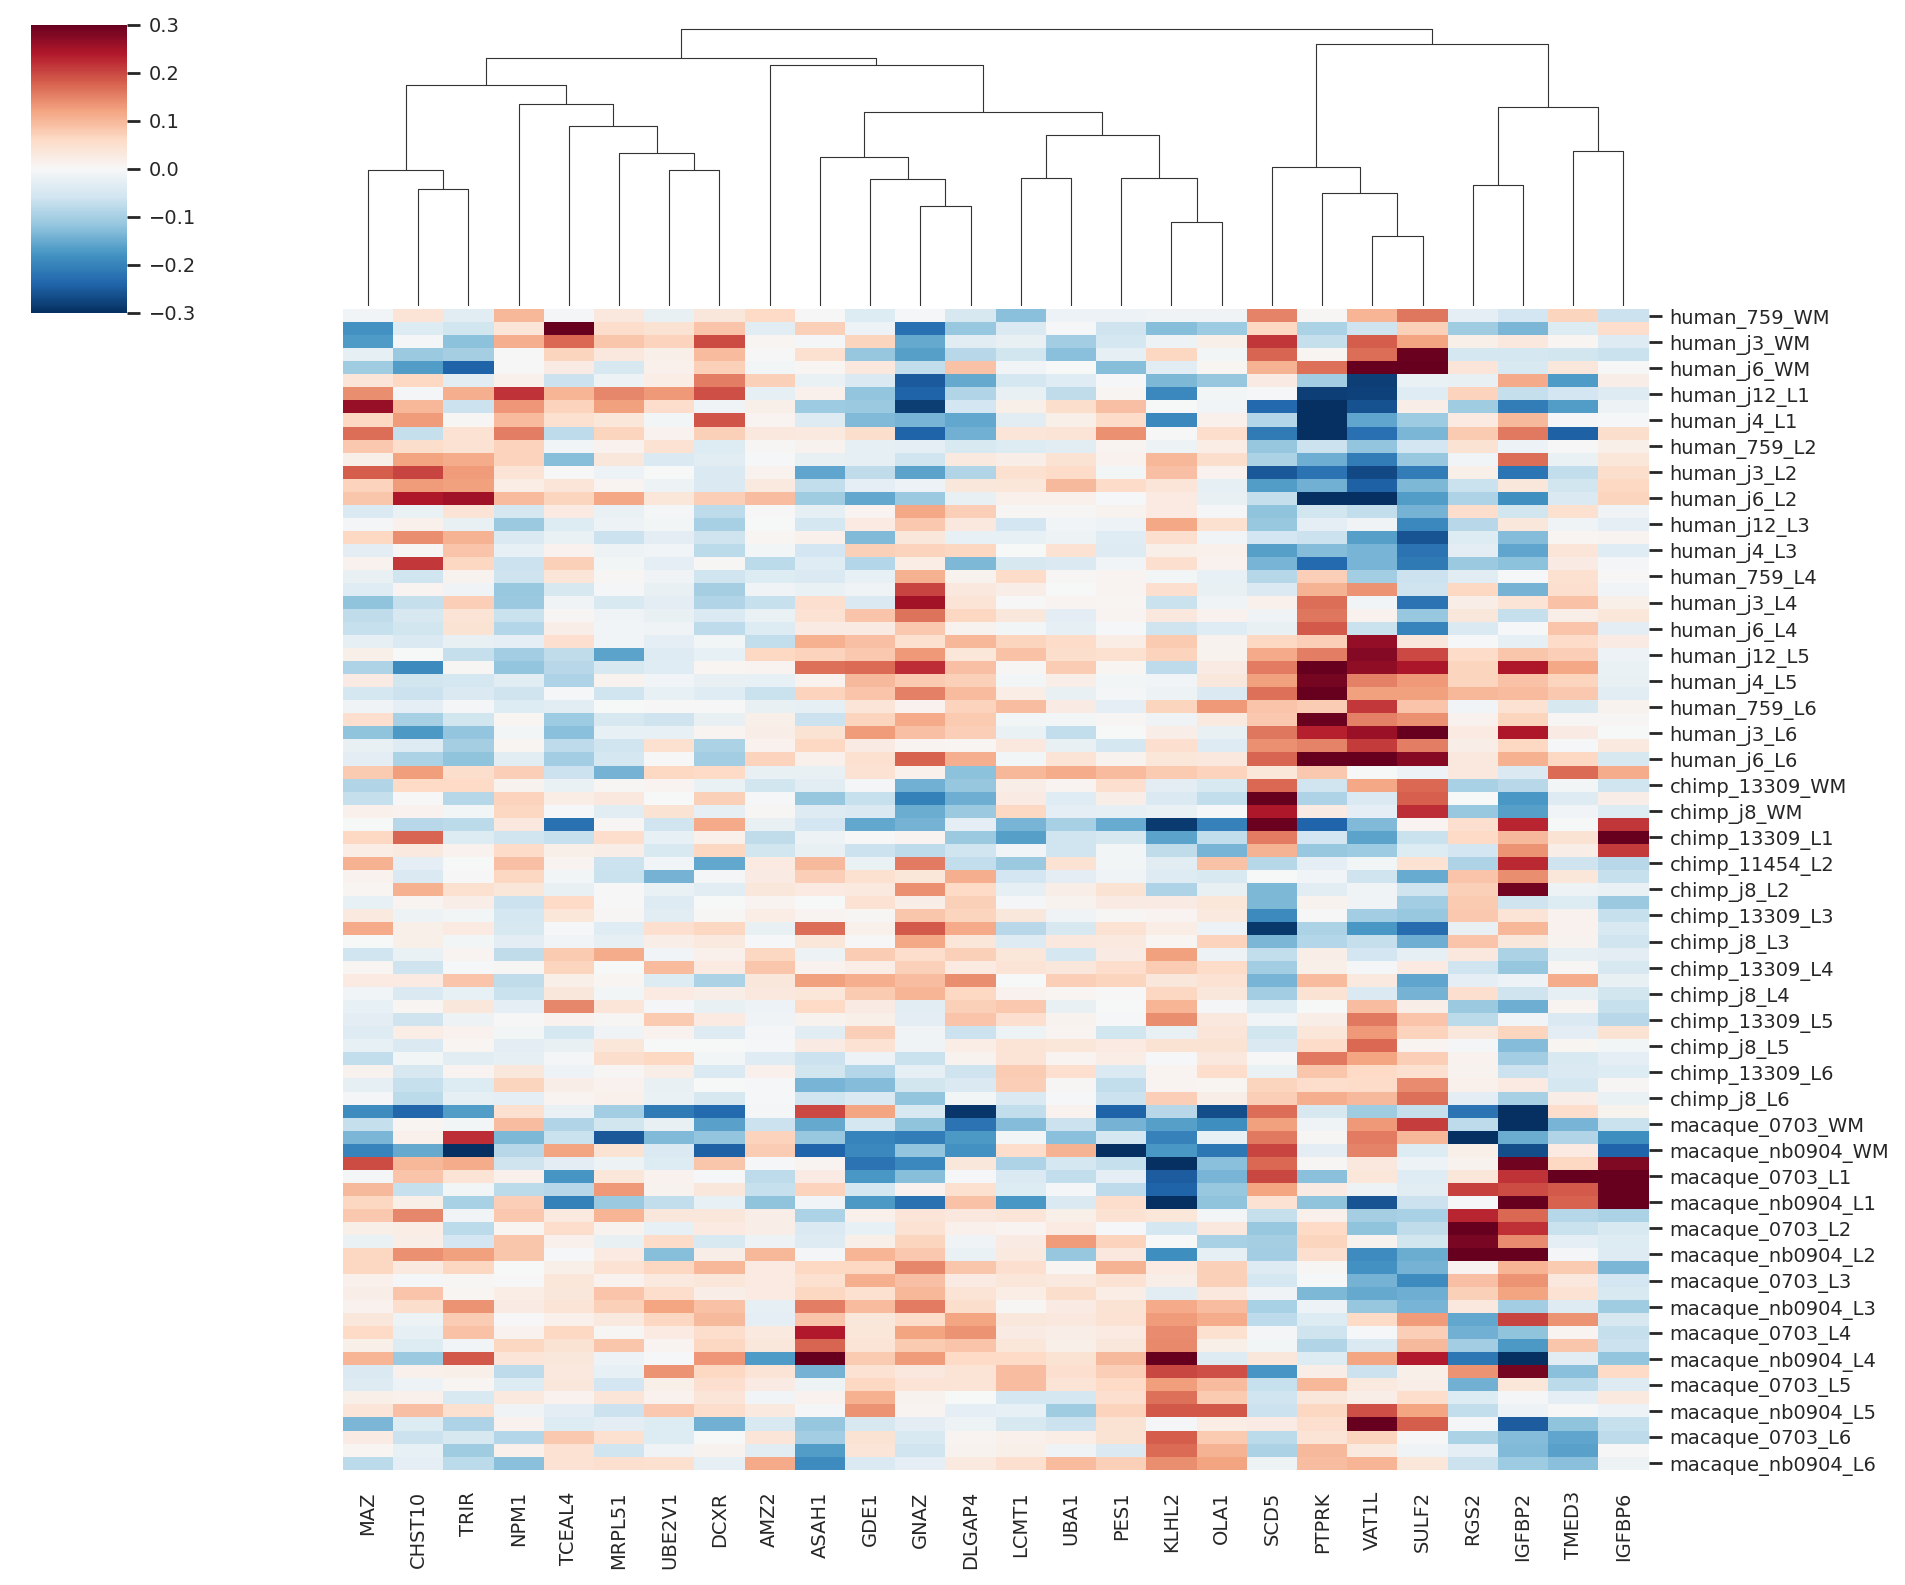

In [14]:
sns.set(font_scale=0.8)
cluster_grid = sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

Visualise correlation matrix

<Axes: >

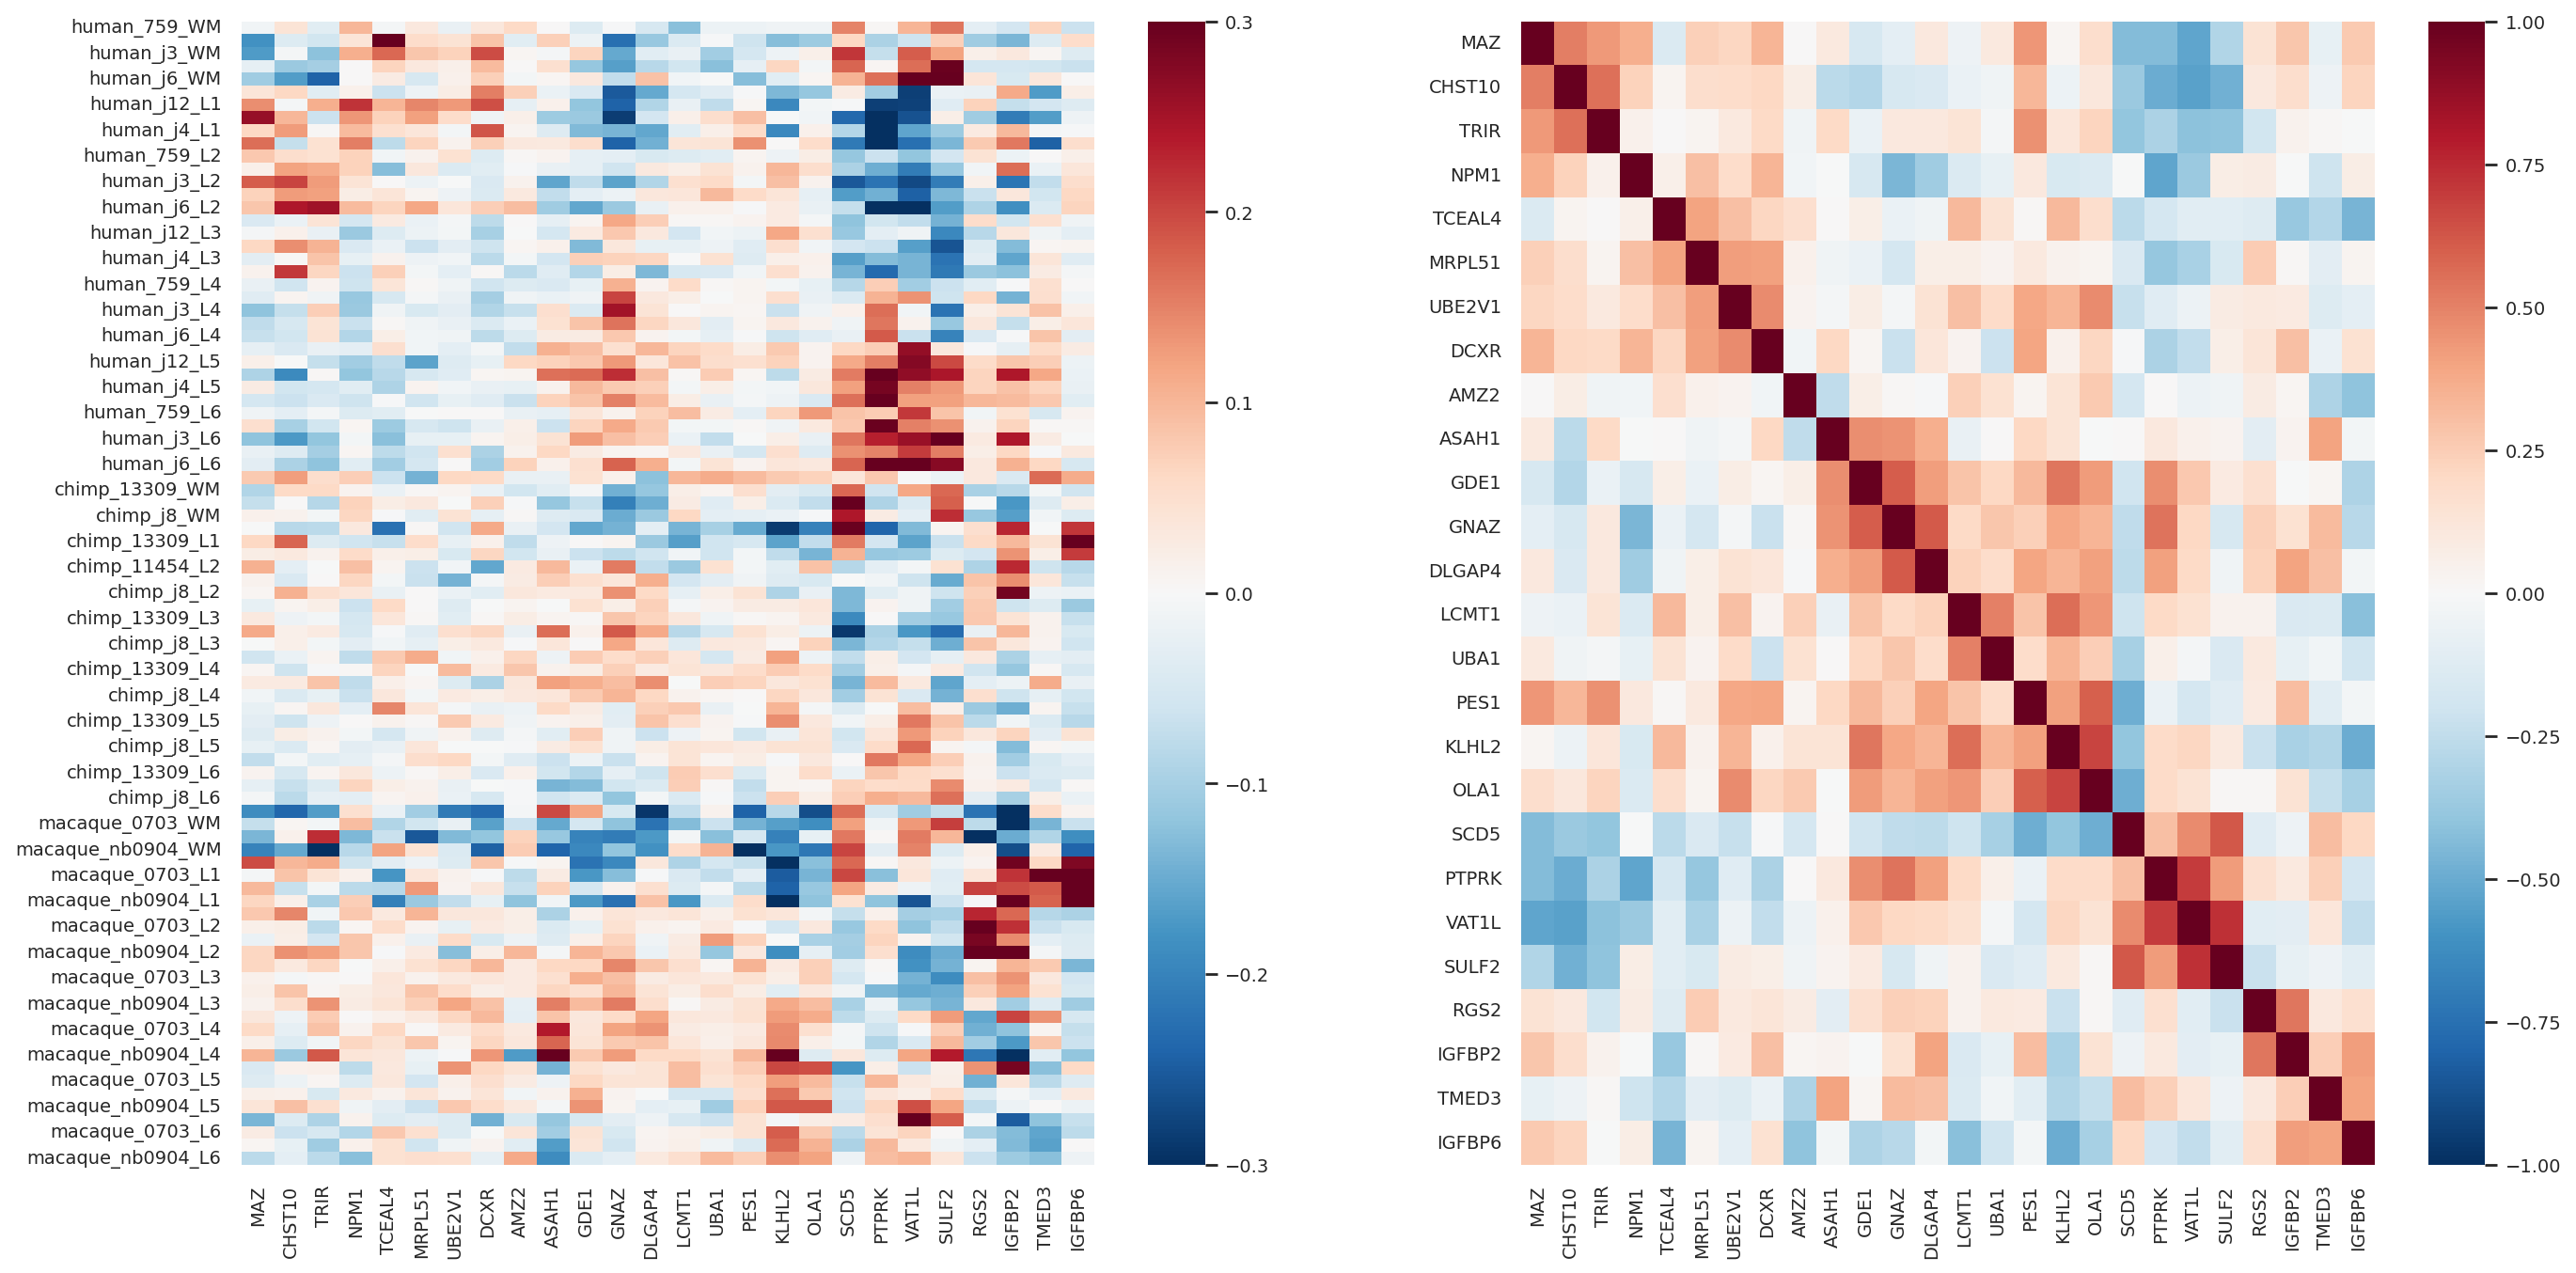

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

gene_order = df_hs.columns[cluster_grid.dendrogram_col.reordered_ind]
sns.heatmap(df_hs[gene_order], cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0, cbar=True, ax=ax[0])

aff_matrix = pairwise_kernels(df_hs.T, metric='cosine')
aff_df = pd.DataFrame(aff_matrix, index=df_hs.columns, columns=df_hs.columns)
sns.heatmap(aff_df.loc[gene_order, gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax[1], vmin=-1, vmax=1)

Cluster genes in 6 clusters

In [16]:
n_clusters = 6
X = df_hs.T
distances = pdist(X, metric='cosine')
Z = linkage(distances, method='ward')
index_order = leaves_list(Z)
gene_order = hs_genes[index_order]
cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')

In [17]:
labels = pd.Series(cluster_labels, index=hs_genes).sort_values()
order = labels.sort_values().index

Save results

In [18]:
labels.to_csv(f'data/human_specific_genes/human_clusters_edgeR_{n_clusters}.csv')

In [19]:
colors = cluster_color[:n_clusters]
clusters = np.arange(1, n_clusters + 1)

Visualise

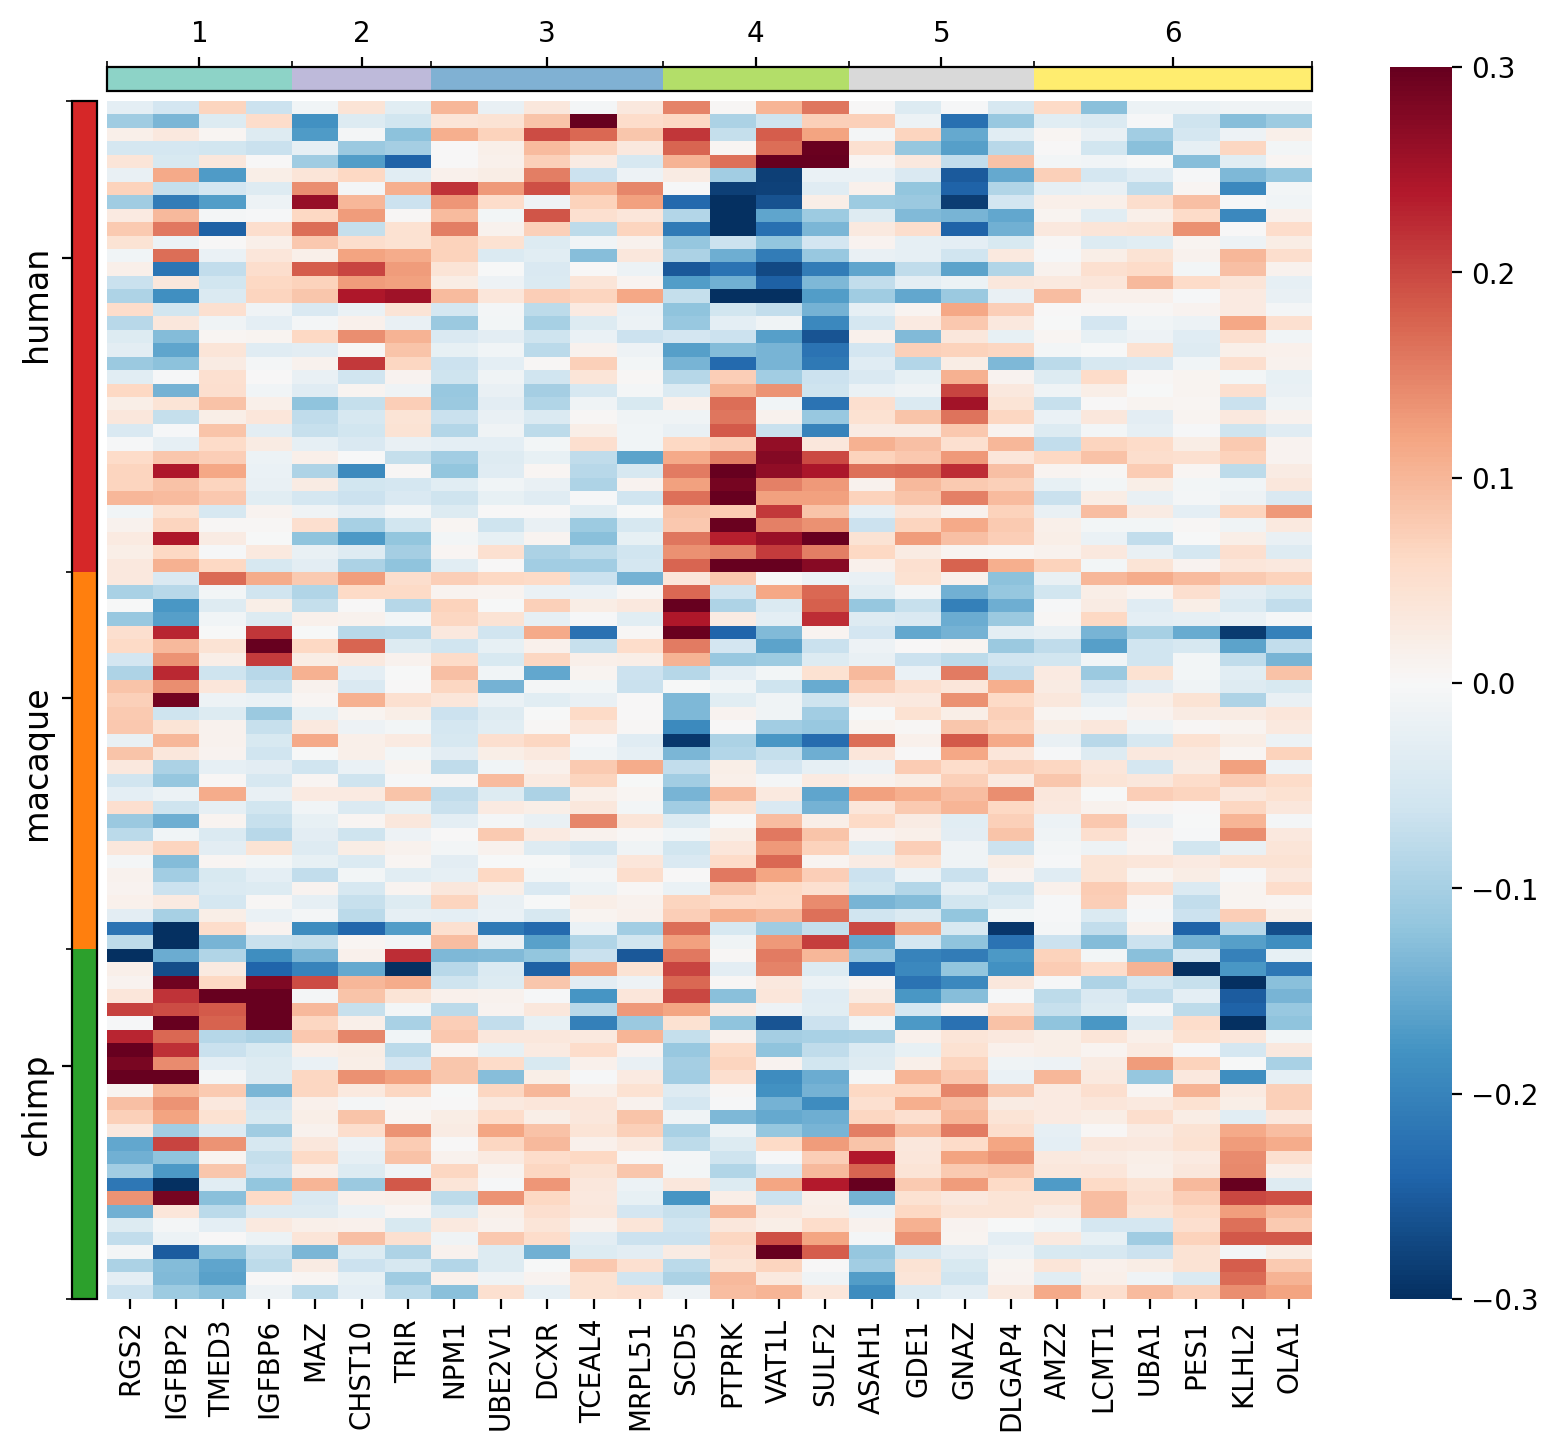

In [20]:
vis.plot_cluster_heatmap(
    df_hs,
    gene_order,
    labels,
    adata_pb.obs.condition,
    clusters,
    cluster_cmap="Set3",
    cond_palette=specie_palette,
    figsize=(10, 8),
    vmax=0.3,
    vmin=-0.3,
    center=0,
    ax=None,
)
plt.savefig(f'{figures_dir}/human_specific_genes_clusters.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_clusters.pdf', bbox_inches='tight')

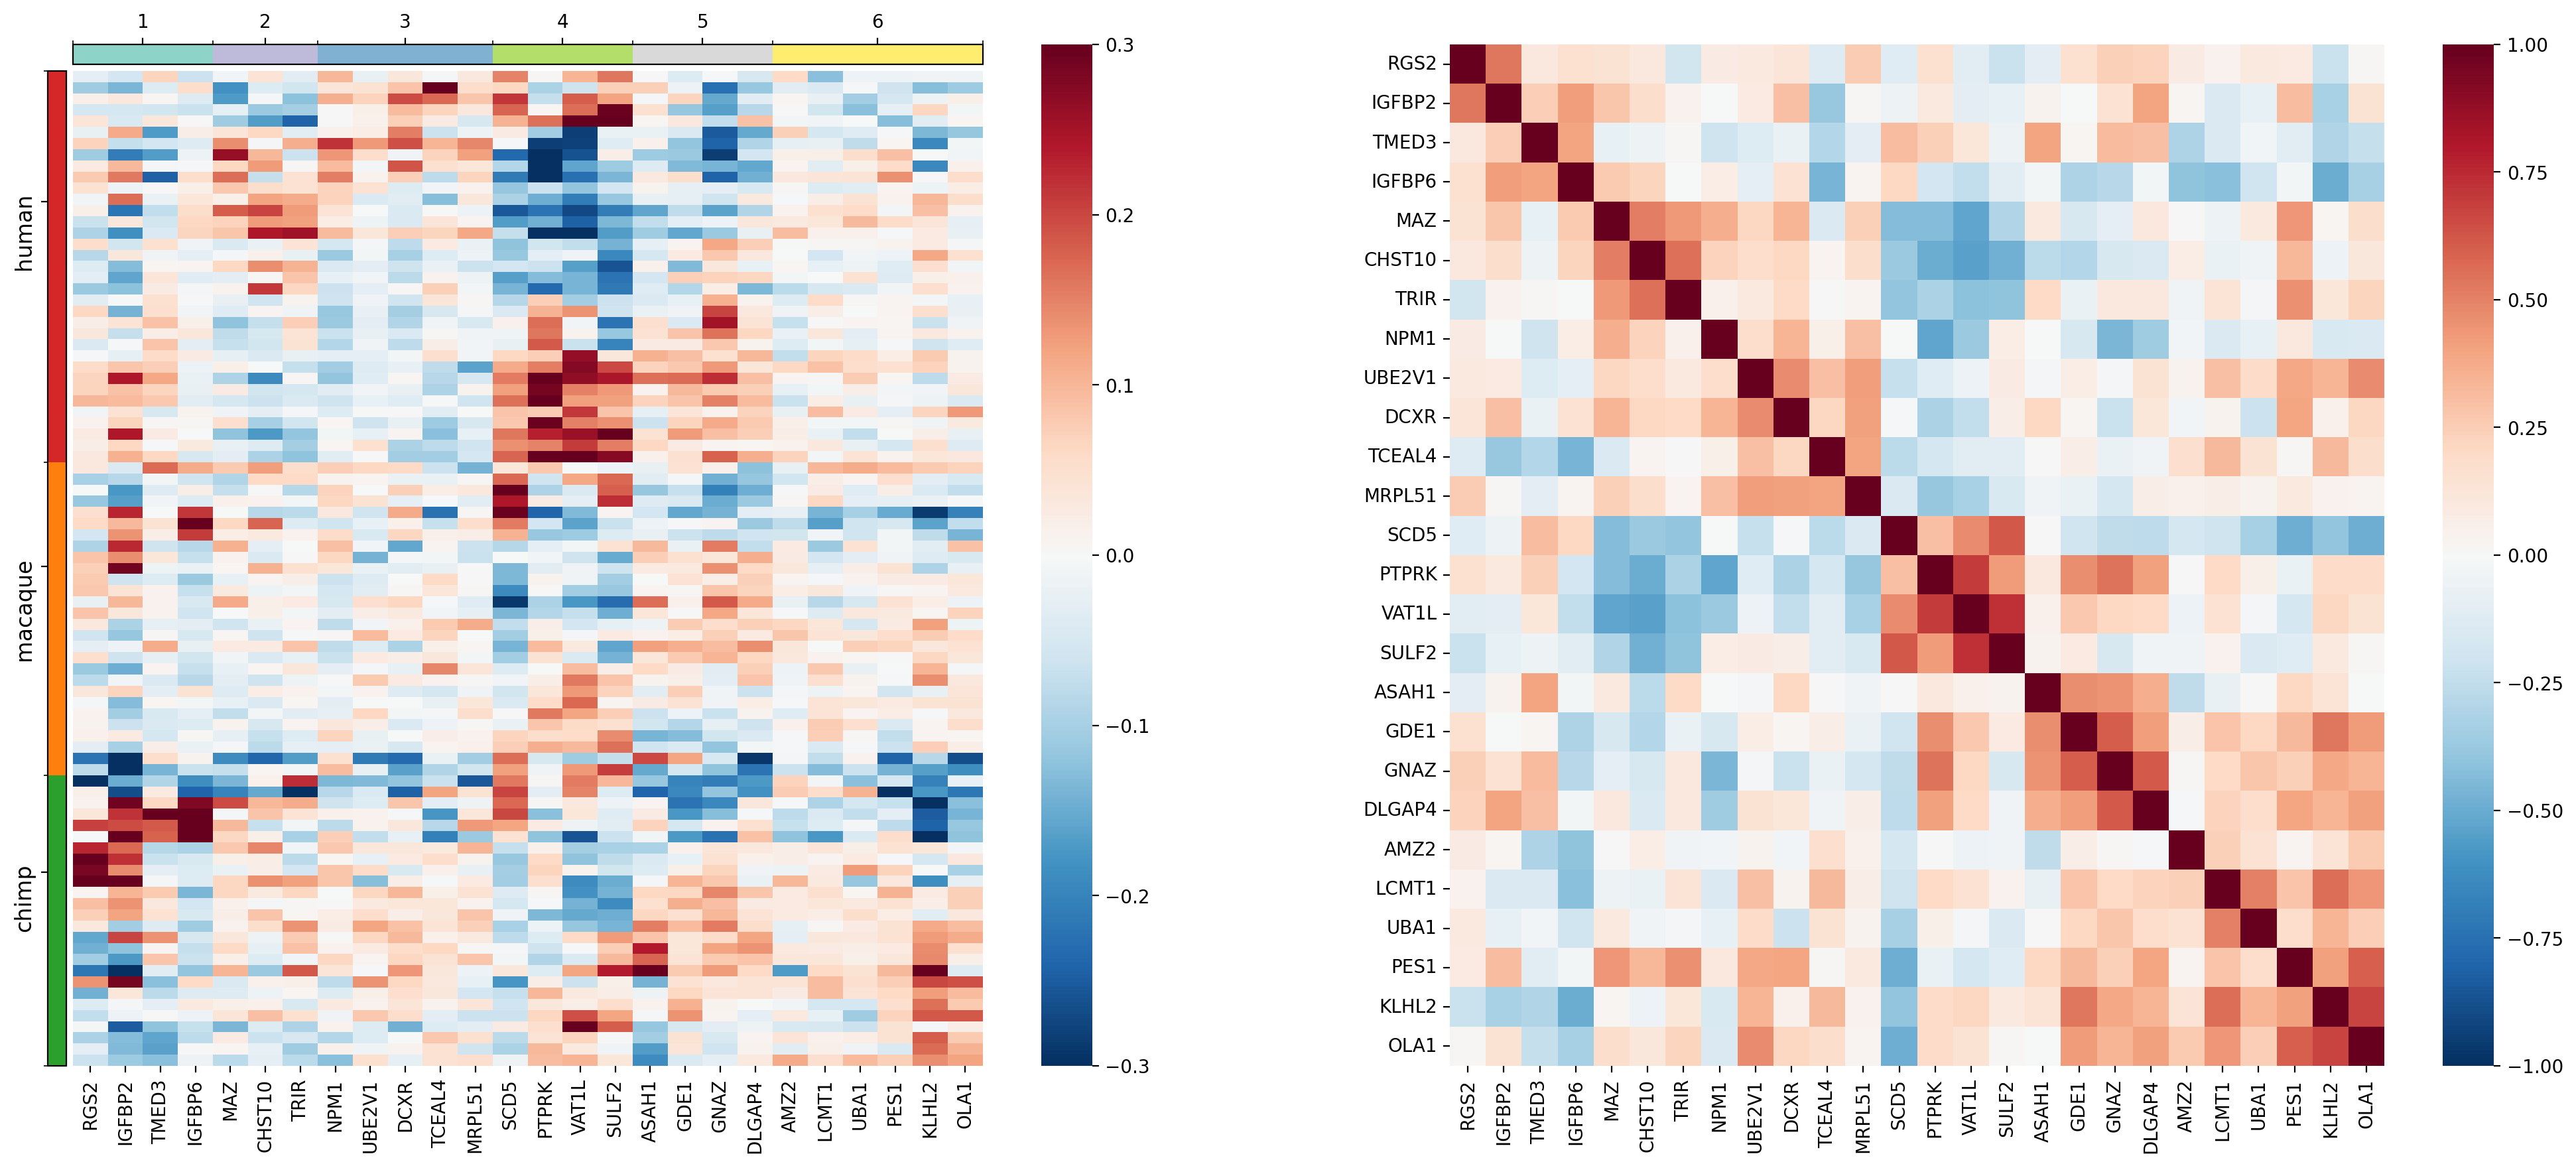

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

vis.plot_cluster_heatmap(
    df_hs,
    gene_order,
    labels,
    adata_pb.obs.condition,
    clusters,
    cluster_cmap="Set3",
    cond_palette=specie_palette,
    figsize=(10, 8),
    vmax=0.3,
    vmin=-0.3,
    center=0,
    ax=ax1,
    fig=fig,
)

aff_matrix = pairwise_kernels(df_hs.T, metric='cosine')
sns.heatmap(aff_df.loc[gene_order, gene_order], cmap="RdBu_r", center=0, cbar=True, ax=ax2, vmin=-1, vmax=1)

plt.savefig(f'{figures_dir}/human_specific_genes_clusters_correlations.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_clusters_correlations.pdf', bbox_inches='tight')

## Visualise average profiles

### Simple average profiles

In [22]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb.obs.layer
df_annotation['condition'] = adata_pb.obs.condition

In [23]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

CHST10      GDE1     KLHL2     TMED3     VAT1L    TCEAL4  \
condition layer                                                               
chimp     L1     0.040722 -0.072976 -0.174603  0.020570 -0.134590 -0.091448   
          L2     0.010692  0.018209 -0.055641 -0.013723 -0.027989 -0.007726   
          L3     0.007115  0.015995  0.015426 -0.001668 -0.090567  0.020278   
          L4    -0.024554  0.071667  0.073990  0.015196 -0.019784  0.049120   
          L5    -0.018871  0.041293  0.066091 -0.015035  0.138455  0.020757   

                     OLA1      RGS2      PES1    IGFBP2  ...     SULF2  \
condition layer                                          ...             
chimp     L1    -0.138834  0.018172 -0.070343  0.153079  ... -0.033391   
          L2     0.004987  0.022262  0.007094  0.217738  ... -0.056419   
          L3     0.029391  0.055420  0.026011  0.028184  ... -0.149047   
          L4     0.029813 -0.001615  0.036643 -0.072510  ... -0.074779   
          L5     0.026936 -0.040766 -0.009166 -0.055317  ...  0.045434   

                   UBE2V1       MAZ      NPM1    IGFBP6     LCMT1      DCXR  \
condition layer                                                               
chimp     L1    -0.043984  0.027805  0.010221  0.265541 -0.104878  0.064412   
          L2    -0.057337  0.042030  0.063715 -0.057857 -0.064547 -0.065399   
          L3    -0.001068  0.029255 -0.049586 -0.072317 -0.023076  0.024156   
          L4     0.017594 -0.009766 -0.054165 -0.040403  0.022317 -0.008020   
          L5     0.021524 -0.029793 -0.016595 -0.029513  0.039193 -0.009279   

                     UBA1    MRPL51      AMZ2  
condition layer                                
chimp     L1    -0.073059  0.025786 -0.052386  
          L2     0.010940 -0.043939  0.028603  
          L3    -0.005550 -0.014416  0.001266  
          L4     0.015441  0.026985  0.053422  
          L5     0.008177  0.016666 -0.010463  

[5 rows x 26 columns]

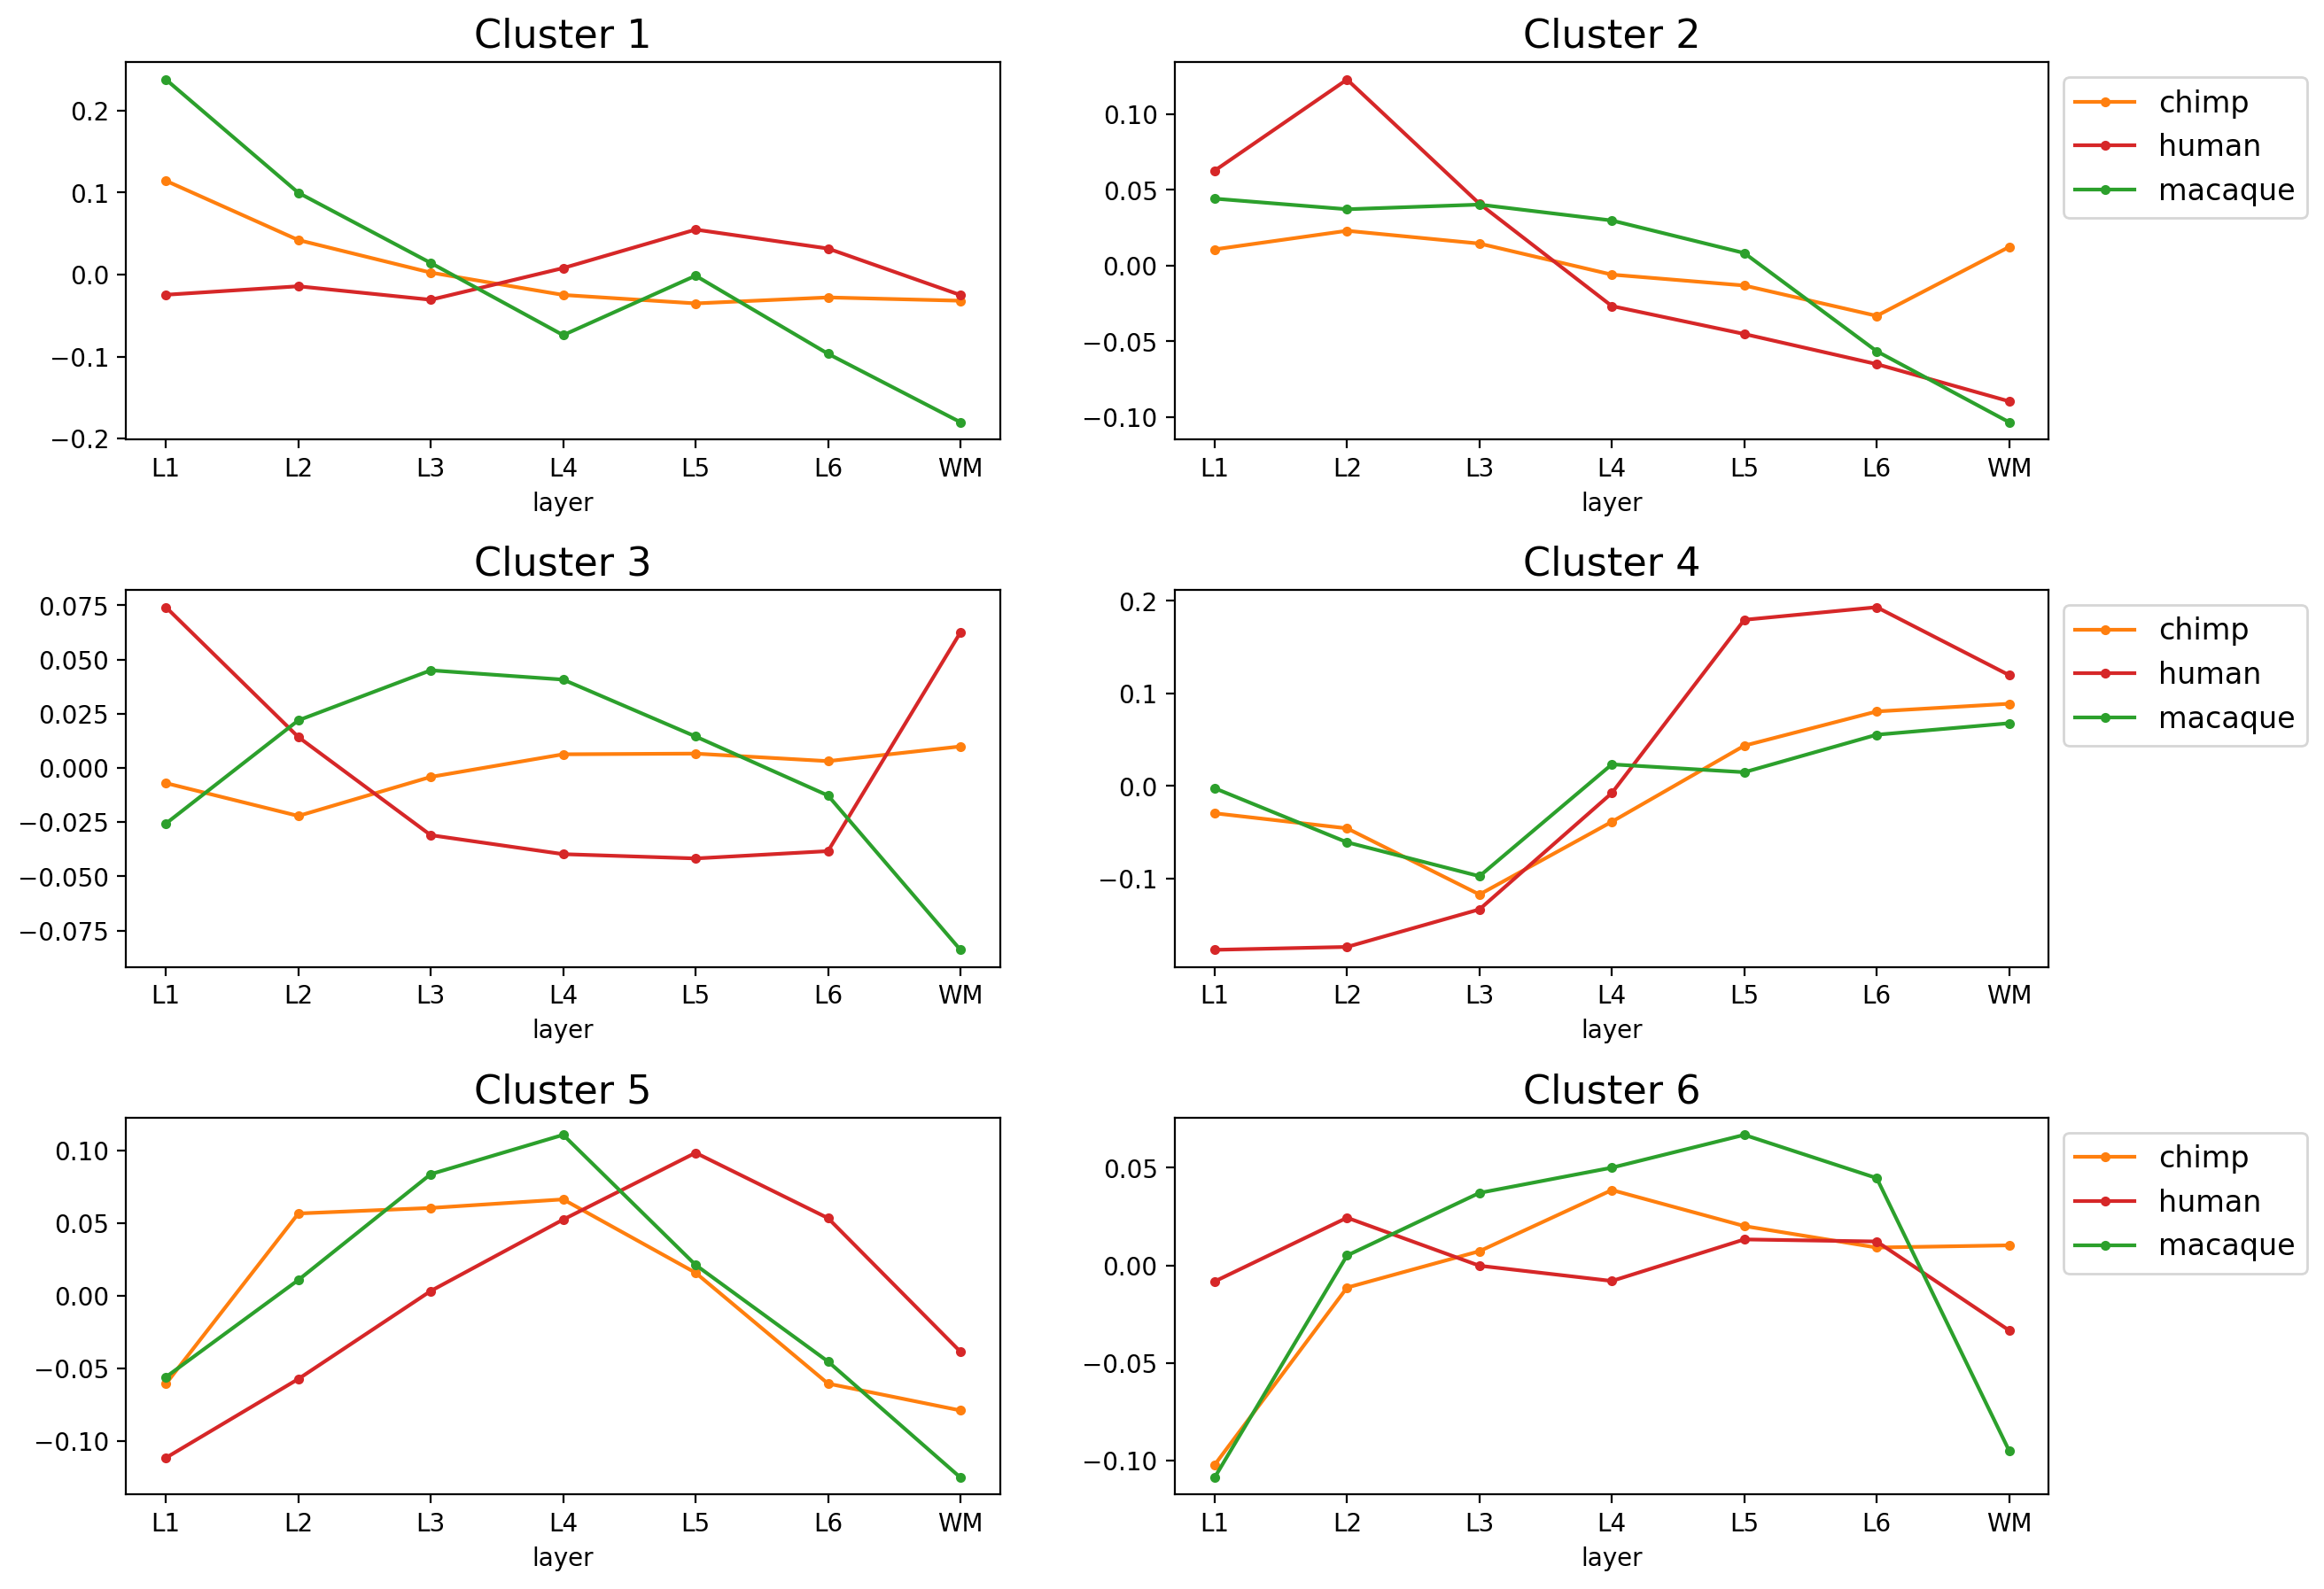

In [24]:
vis.plot_cluster_profiles(
    layer_mean,
    labels,
    layers,
    specie_palette,
    n_clusters=None,
    figsize=(14, None),
    hspace=0.4,
    marker=".",
    title_prefix="Cluster ",
)

plt.savefig(f'{figures_dir}/human_specific_genes_profiles.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_profiles.pdf', bbox_inches='tight')
plt.show()

### Approximate with splines

In [25]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [26]:
df_cont = df_annotation.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [27]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, hs_genes.size))
df_list = []

for specie in conditions:
    for i, gene in enumerate(hs_genes.to_list()):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=hs_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

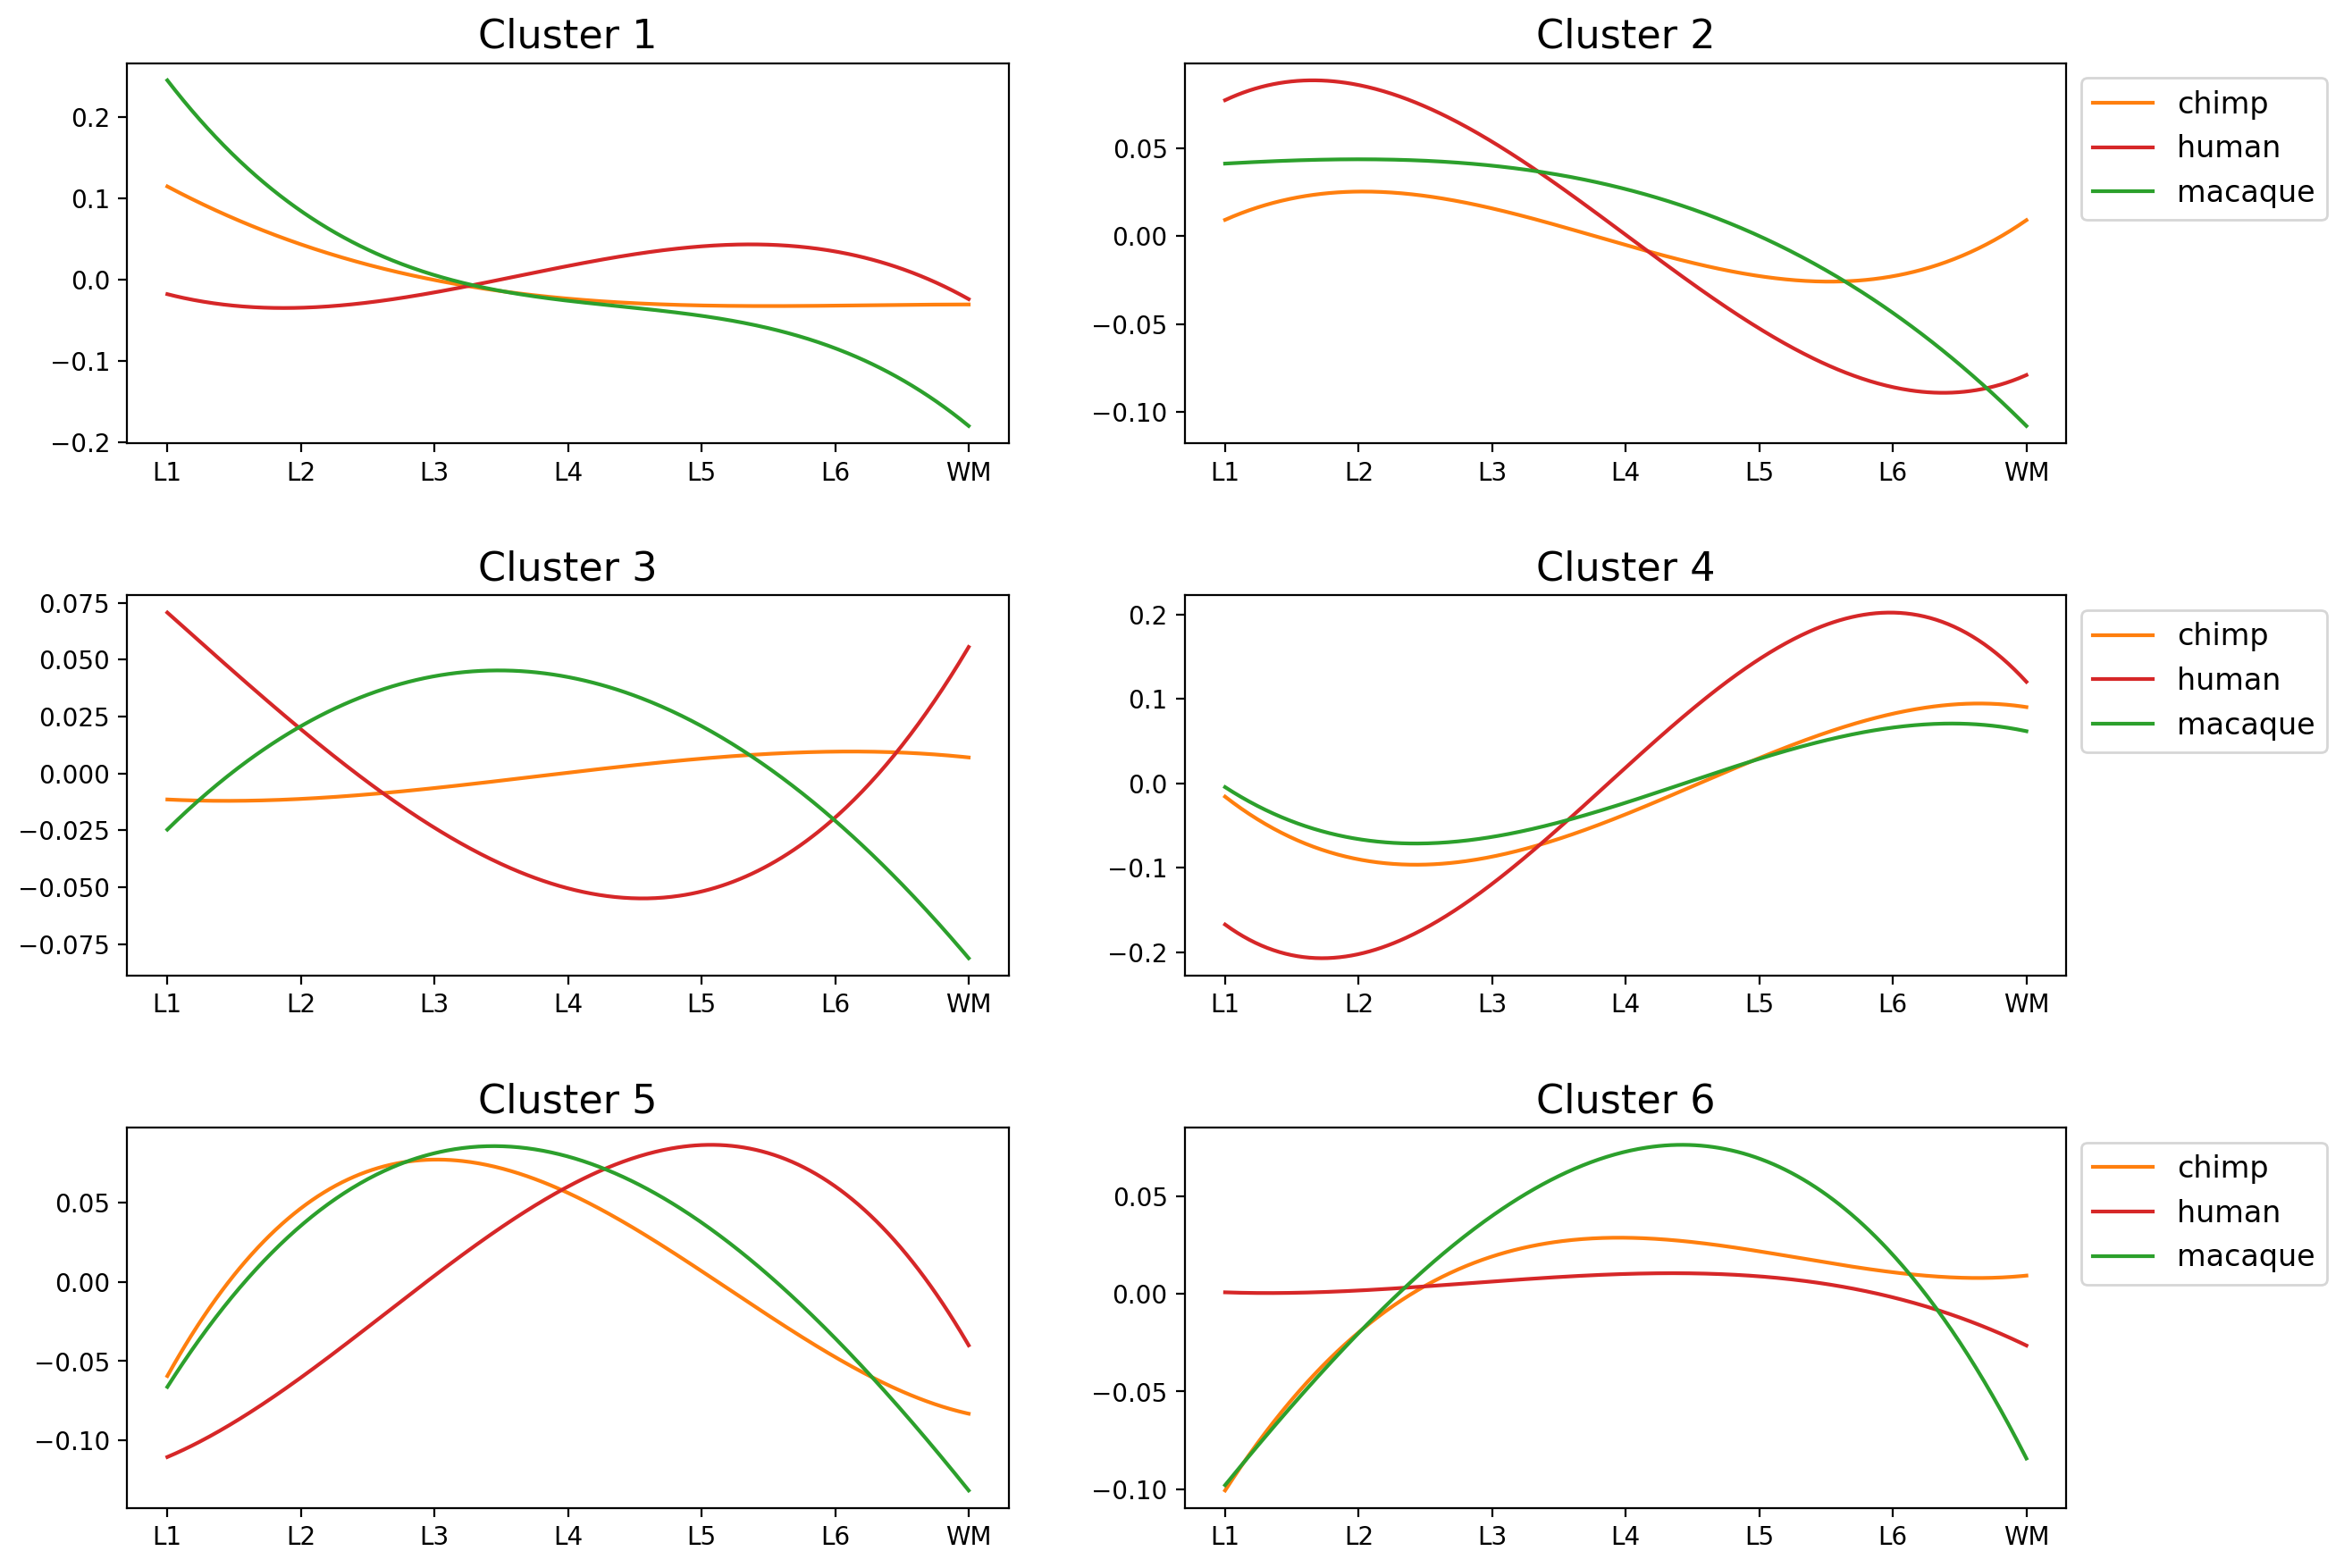

In [28]:
vis.plot_cluster_spline_profiles(
    grid,
    df_spline,
    labels,
    layers,
    specie_palette,
    n_clusters=None,
    figsize=(14, None),
    hspace=0.4,
    title_prefix="Cluster ",
)

plt.savefig(f'{figures_dir}/human_specific_genes_profiles_splines.jpg', bbox_inches='tight')
plt.savefig(f'{figures_dir}/human_specific_genes_profiles_splines.pdf', bbox_inches='tight')
plt.show()

## Visualise cluster distribution across categories

In [29]:
labels.name = 'cluster'
merge_df = category_labels.to_frame().merge(labels, left_index=True, right_index=True)
merge_df.columns = ['category', 'cluster']
merge_df.head()

,category,cluster
CHST10,maybe human-specific,2
GDE1,maybe human-specific,5
KLHL2,human-specific,6
TMED3,human-specific,1
VAT1L,maybe human-specific,4


In [30]:
sankey_df = merge_df.groupby('cluster').value_counts()
sankey_df.head(5)

cluster  category            
1        human-specific          4
2        maybe human-specific    3
3        human-specific          3
         maybe human-specific    2
4        maybe human-specific    3
Name: count, dtype: int64

In [31]:
source_label = list(range(1, len(labels.unique()) + 1))
target_label = ['human-specific', 'age-specific', 'maybe human-specific', 'maybe age-specific']
sankey_label = source_label + target_label

cmap = plt.get_cmap('Set3')
hex_colors = list(map(to_hex, cmap.colors))
source_color = hex_colors[:len(source_label) + 1]
target_color = [to_hex(color_dict_labels[key]) for key in target_label]

source_list = []
target_list = []
value_list = []
link_color_sc = []
link_color_tar = []

for sc_lab, tg_lab in sankey_df.index.to_list():
    source_list.append(sankey_label.index(sc_lab))
    target_list.append(sankey_label.index(tg_lab))
    value_list.append(sankey_df.loc[sc_lab, tg_lab])
    link_color_sc.append(hex_colors[sc_lab - 1])
    link_color_tar.append(to_hex(color_dict_labels[tg_lab]))

source_label = list(map(lambda x: f'clust{x}', source_label))
sankey_label = source_label + target_label

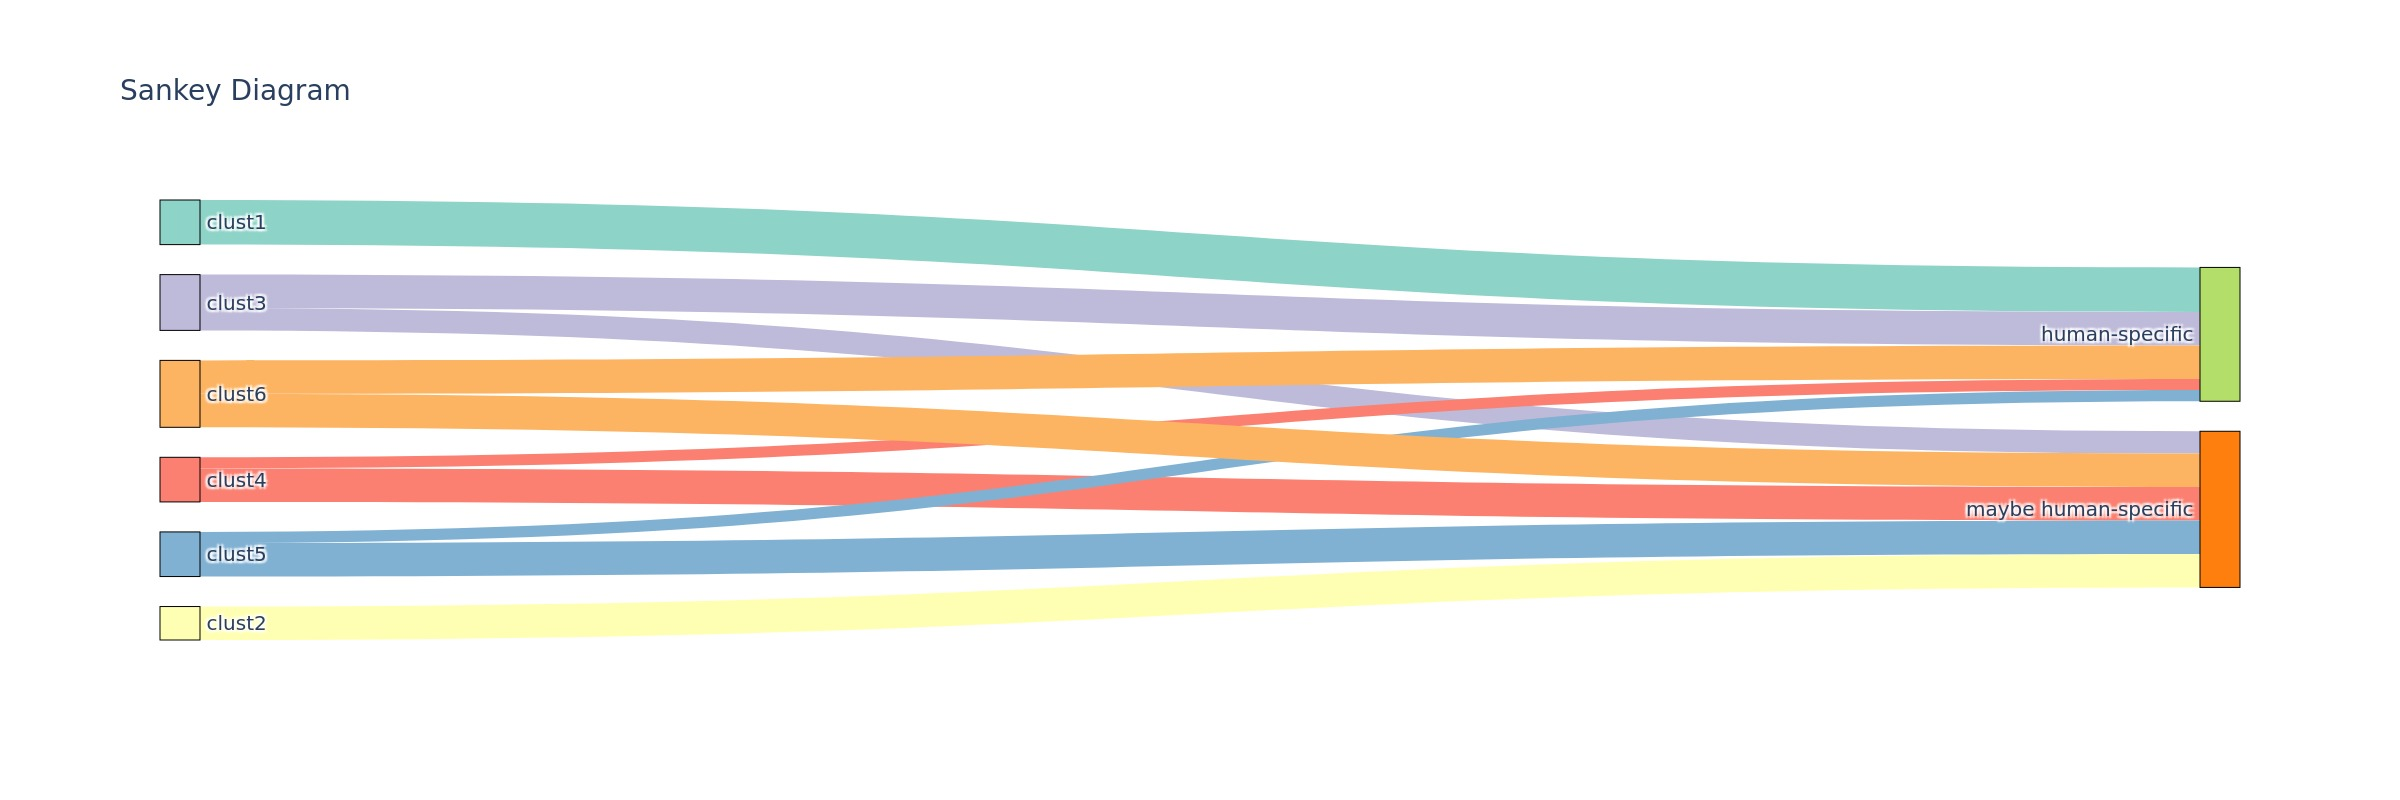

In [32]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = sankey_label,
      color = source_color + target_color
    ),
    link = dict(
      source = source_list, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target_list,
      value = value_list,
      color=link_color_sc
  ))])

fig.update_layout(title_text="Sankey Diagram", font_size=10)

fig.write_image(f"{figures_dir}/my_figure.jpg", width=800, height=600, scale=2)
fig.write_image(f"{figures_dir}/my_figure.pdf")

img_bytes = fig.to_image(format="jpg", width=1200, height=400, scale=2)
Image(img_bytes)